In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import norm
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

#### Station data Tuolumne

In [2]:
path = '/Users/meganmason491/Documents/research/sierra/data/stations/*.csv' #BSU
# path = '/Users/megmason/research/sierra/data/station/*0930.csv' #mac
flist = glob.glob(path)

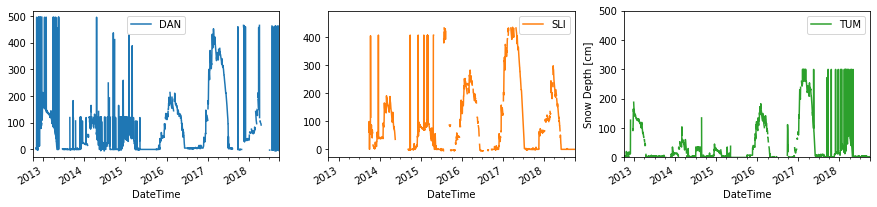

In [3]:
# merge snow depth [in] CSVs

# load single df, first in flist
df = pd.read_csv(flist[0], header=0, usecols=[0,1], names=['DateTime', flist[0].split("/")[-1][:3]])
df['DateTime'] = pd.to_datetime(df['DateTime']) #datetime dtype
df = df.set_index('DateTime') #set datatime as index

# add columns to df
for f in sorted(flist):  
    tmp_df = pd.read_csv(f, usecols=[0,1]) # load each csv as a tmp_df
    site_id = f.split("/")[-1][:3] #grab site id name from filename
    df.loc[:,site_id] = tmp_df['SNOW DP INCHES'].values # insert temp_df column into df at location (all rows, new site_id name)
    
df=df.replace('--', np.nan)  #raw data has '--' string to mark no value, replace w/ NANs
df=df.astype(float) #cast as float

df = df * 2.54 # convert raw [inches] to [cm] of snow
#note - data have a few negatives (-1,-2), but not too large...

#~~~~plot it
df.plot(subplots=True, layout=(1,3), figsize=(15,3))
plt.ylabel('Snow Depth [cm]')
plt.ylim(0,500)
plt.legend(loc='best')

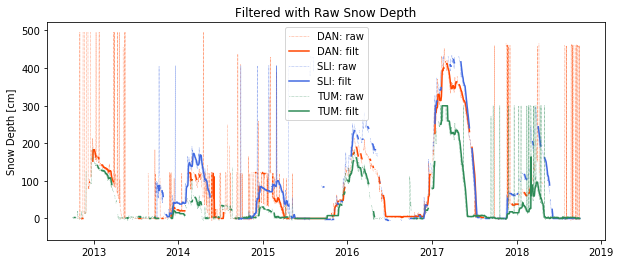

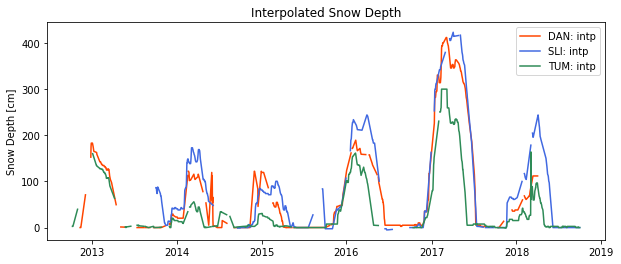

In [4]:
# Marks help
df_filt = df.copy() 
stations = list(df.columns)
colors = ['r','b','g']
colors = ['orangered','royalblue','seagreen']

# simple max filter
max_filter =  440
idx = df_filt > max_filter
df_filt[idx] = np.nan

# remove negatives
df_filt[(df_filt >= 0)]

# rolling median filter
df_filt = df_filt.rolling(10).median()

fig = plt.figure(figsize=(10,4))
a = plt.gca()

for i, stn in enumerate(stations):
    a.plot(df.index, df[stn].values,
           linewidth = 0.5,
           linestyle = ':',
           color = colors[i],
           label = '{}: raw'.format(stn))
    a.plot(df.index, df_filt[stn].values,
           color = colors[i],
           label = '{}: filt'.format(stn))

a.legend(loc='best')
a.set_title('Filtered with Raw Snow Depth')
a.set_ylabel('Snow Depth [cm]')
plt.show()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#interpolate -- dangerous!
df_intp = df_filt.interpolate(method='linear', limit = 20)

fig = plt.figure(figsize=(10,4))
a = plt.gca()

for i, stn in enumerate(stations):
    a.plot(df_intp.index, df_intp[stn].values,
           color = colors[i],
           label = '{}: intp'.format(stn))
    
a.legend(loc='best')
a.set_title('Interpolated Snow Depth')
a.set_ylabel('Snow Depth [cm]')
plt.show()

#### Add lidar data





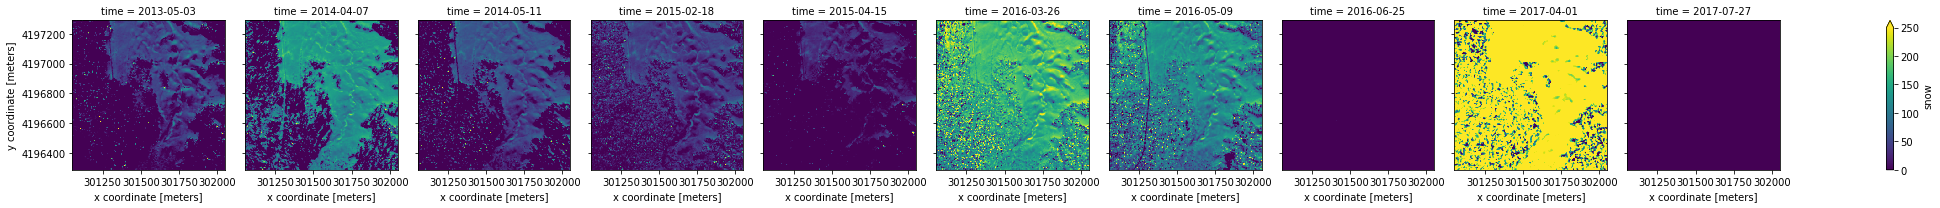

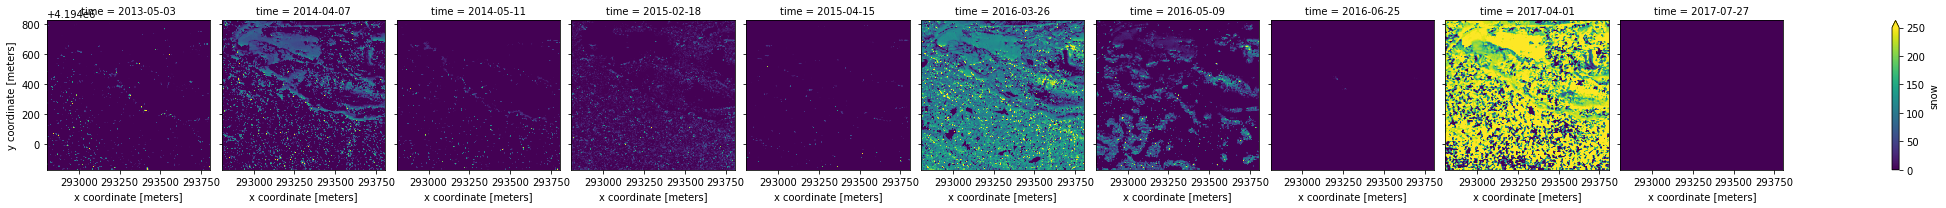

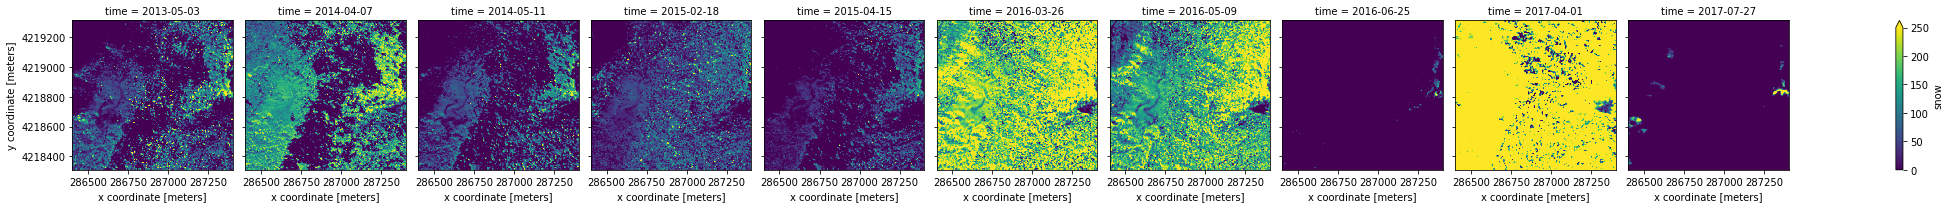

<xarray.Dataset>
Dimensions:  (time: 51, x: 334, y: 334)
Coordinates:
  * x        (x) float32 301053.0 301056.0 301059.0 ... 302049.0 302052.0
  * y        (y) float32 4197288.0 4197285.0 4197282.0 ... 4196292.0 4196289.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<chunksize=(334, 318), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(334, 318), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(334, 318), meta=np.ndarray>
Data variables:
    snow     (time, y, x) int16 dask.array<chunksize=(1, 334, 318), meta=np.ndarray>


In [33]:
fname = '/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow.nc' #3m BSU
# fname = '/Users/megmason/research/sierra/data/compiled_SUPERsnow_20m.nc' #20m mac

#open data
ds = xr.open_dataset(fname, chunks={'time':1,'x':1000,'y':1000})
ds['snow'] = ds.snow / 10
ds.attrs['units'] = 'cm'
ds=ds.astype(np.int16, copy=False)
ds.close()

#station slices
pix = 500
dan = ds.sel(x=slice(301552.-pix, 301552.+pix), y=slice(4196789.+pix, 4196789.-pix)) #x=301551.88, y=4196788.62
tum = ds.sel(x=slice(293306.-pix, 293306.+pix), y=slice(4194327.+pix, 4194327.-pix)) #x=293306.56, y=4194327.33
sli = ds.sel(x=slice(286904.-pix, 286904.+pix), y=slice(4218811.+pix, 4218811.-pix)) #x=286903.89, y=4218811.44


d = dan.isel(time=slice(2,51,5)).snow.plot(x='x', y='y', col='time', vmax=250); plt.show()
t = tum.isel(time=slice(2,51,5)).snow.plot(x='x', y='y', col='time', vmax=250); plt.show()
s = sli.isel(time=slice(2,51,5)).snow.plot(x='x', y='y', col='time', vmax=250); plt.show()
#plot
# plt.imshow(dan.snow[0]); plt.show()
# plt.imshow(tum.snow[0]); plt.show()
# plt.imshow(sli.snow[0]); plt.show()
print(dan)

# d = dan.snow.plot(x='x', y='y', col='time', col_wrap=5, cmap='jet', cbar_kwargs={'label': 'snow depth [cm]'}); plt.show()

# snow_plot = ds.snow.plot(x='x', y='y', col='time', col_wrap=3,
#                          cmap='RdBu',
#             cbar_kwargs={'label': 'snow depth [cm]'})
# plt.minorticks_on()
# plt.gca().xaxis.set_minor_locator(mpl.ticker.MultipleLocator(30))
# plt.gca().yaxis.set_minor_locator(mpl.ticker.MultipleLocator(30))
# plt.grid(which="both", linewidth=0.5,color="k")
# plt.tick_params(which="minor", length=0)
# plt.show()



In [ ]:
# foo = ds.sel(x=slice(306680., 306780.), y=slice(4234040., 4233090.))
foo = ds.sel(x=slice(254000., 254100.), y=slice(4234060., 4233960.))

In [ ]:
foo.values
plt.imshow(foo.snow[0])

#### EXTRA STUFF BELOW

In [ ]:
# attempt to clean data with IQR

# df_clean = pd.DataFrame().reindex_like(df)
# water_years=list(range(2012,2019))

# for wy in water_years:
#     df_wy = df.loc['{}-10-01'.format(wy) : '{}-09-30'.format(wy+1)]
# #     print(data.index)
    
#     #compute the inner-quartile range (5-95% of data)
#     Q1 = df_wy.quantile(0.05)
#     Q3 = df_wy.quantile(0.95)
# #     IQR = Q3 - Q1

#     #remove outliers
#     df_tmp = df_wy[(df_wy > Q1) & (df_wy < Q3)] #everything between the IQR
#     df_tmp = df_tmp[(df_tmp >= 0)] #remove negatives
#     print('YEAR:', wy)
# #     print(df.max())
# #     print(df_tmp.max())
#     print(df_tmp)
#     print('MINI CLEAN', df_clean)
# #     df.plot()
# #     df_wy.plot()
#     df_clean.append(df_tmp)
# # print('RAW\n', df.max(), df.min()) #df (raw)
# # print('\nCLEAN\n', df_clean.max(), df_clean.min()) # df_clean

# df_clean.plot()


In [ ]:
# #compute the inner-quartile range (5-95% of data)
# Q1 = df.quantile(0.05)
# Q3 = df.quantile(0.95)
# IQR = Q3 - Q1

# #remove outliers
# df_out = df[(df > Q1) & (df < Q3)] #everything between the IQR
# df_out = df_out[(df_out >= 0)] #remove negatives
# print('OG\n', df.max(), df.min()) #df (raw)
# print('\nOUT\n', df_out.max(), df_out.min()) # df_out (clean)

# #ref: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

In [ ]:
df.boxplot()

In [ ]:
#extra stuff...
boo = pd.DataFrame(np.random.randint(0,5,size=(10, 4)), columns=list('ABCD'))
boo.dtypes
boo

boo.replace(0, 'bla', inplace=True)
boo